Loaded data: 1552210 rows, 44 columns
Train set: 1500 rows, Test set: 300 rows
Starting preprocessing (no ID/Time)...
Handling missing values (mean imputation)...
Imputing NaNs for columns: ['HR', 'SBP', 'DBP', 'Resp', 'Temp', 'O2Sat', 'Lactate', 'WBC']
Scaling features: ['HR', 'SBP', 'DBP', 'Resp', 'Temp', 'O2Sat', 'Lactate', 'WBC', 'ICULOS']
Saving scaler to rl_sepsis_model_no_id_time_mort\scaler.pkl
Preprocessing finished.


c:\Users\mouni\anaconda3\envs\tun_law_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Updated target model weights.
Starting training (row-by-row)...
Total rows: 1500, Steps per episode: 1000

--- Episode 1/3 ---


Episode 1 Steps: 100%|██████████| 1000/1000 [04:43<00:00,  3.52it/s]


Episode 1: Avg Reward/Step = -0.034, Avg Loss = 0.0057, Epsilon = 0.153, Total Steps = 1000

--- Episode 2/3 ---


Episode 2 Steps:  13%|█▎        | 63/499 [00:18<02:15,  3.22it/s]

Updated target model weights.


Episode 2 Steps: 100%|██████████| 499/499 [02:43<00:00,  3.04it/s]


Episode 2: Avg Reward/Step = -0.017, Avg Loss = 0.0051, Epsilon = 0.056, Total Steps = 1499

--- Episode 3/3 ---
Reached end of data for training.
Training finished.
Saved training progress plot to rl_sepsis_model_no_id_time_mort\training_progress.png
Evaluating agent on the test set...

--- Starting Evaluation (row-by-row) ---


Evaluating Steps: 100%|██████████| 299/299 [00:22<00:00, 13.18it/s]


Evaluation Results:
  Average Reward per Step: 0.124
  Action Distribution:
0    0.996656
3    0.003344
Name: proportion, dtype: float64

Final Evaluation Summary:
  Average Reward per Step: 0.12357859531772576
  Action Distribution: {0: 0.9966555183946488, 3: 0.0033444816053511705}


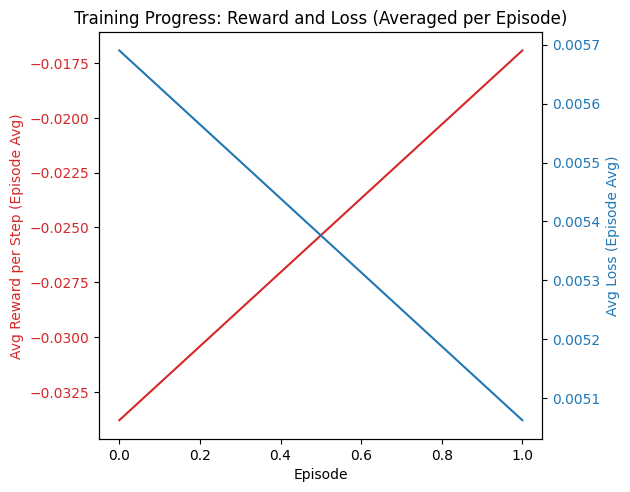

In [4]:
import pandas as pd
import numpy as np
import random
import os
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix # Note: AUC might be hard to interpret without patient context
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout # Removed LSTM as sequence context is weak
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import pickle # To save/load scaler and agent
import matplotlib.pyplot as plt # Ensure matplotlib is imported

# --- Configuration ---
DATA_FILE = 'Dataset.csv' # Your data file path
MODEL_SAVE_DIR = 'rl_sepsis_model_no_id_time_mort' # Changed save dir name
SCALER_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, 'scaler.pkl')
# Corrected filename extension for weights
AGENT_WEIGHTS_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, 'dqn_agent_weights.weights.h5')

# Ensure save directory exists
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# State features - REMOVED TimeSinceLastAction, Age, Gender
# We only use the dynamic vitals/labs available
STATE_FEATURES = [
    'HR', 'SBP', 'DBP', 'Resp', 'Temp', 'O2Sat', 'Lactate', 'WBC',
    'ICULOS'
]
# STATIC_FEATURES = [] # No longer used
TARGET_FEATURES = ['SepsisLabel'] # REMOVED Mortality
# ID_COLUMN = None # No longer used
# TIME_COLUMN = None # No longer used

# Action space
NUM_ACTIONS = 6
# 0: Do nothing, 1: IV fluids, 2: Antibiotics, 3: Vasopressors, 4: Alert clinician, 5: Combo (fluids + antibiotics)

# Hyperparameters
GAMMA = 0.95
LEARNING_RATE = 0.001
MEMORY_SIZE = 50000
BATCH_SIZE = 64
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.998 # Adjusted decay slightly
TARGET_UPDATE_FREQ_STEPS = 1000 # Update target network every N training steps

# Reward function constants - REMOVED REWARD_DEATH
REWARD_STABILIZED = 1.0
REWARD_IMPROVED = 0.5
REWARD_DETERIORATE = -0.5
REWARD_PENALTY = -0.05
REWARD_SEPSIS_ONSET = -0.75

# --- Preprocessing ---

def preprocess_data(df, state_features, target_features):
    """
    Preprocesses the raw ICU data without ID or Time columns.
    Handles missing values and scales features.
    """
    print("Starting preprocessing (no ID/Time)...")
    # Ensure correct types
    for col in state_features + target_features:
         if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Select relevant columns
    all_needed_cols = list(set(state_features + target_features)) # Avoid duplicates
    df_processed = df[all_needed_cols].copy()

    # --- Missing Value Imputation ---
    # 1. Impute NaNs using global mean/median (no ffill without patient context)
    print("Handling missing values (mean imputation)...")
    numeric_cols_for_impute = [f for f in state_features if f in df_processed.columns and df_processed[f].isnull().any()]
    if numeric_cols_for_impute:
        print(f"Imputing NaNs for columns: {numeric_cols_for_impute}")
        imputer = SimpleImputer(strategy='mean') # Or 'median'
        # Fit imputer only on training data in a real scenario. Here, we fit on the input df.
        df_processed[numeric_cols_for_impute] = imputer.fit_transform(df_processed[numeric_cols_for_impute])
        # Impute target feature if needed (e.g., SepsisLabel - though unlikely to be missing)
        if any(f in target_features for f in numeric_cols_for_impute):
             print("Warning: Imputing target features. Ensure this is intended.")


    # --- Feature Scaling ---
    scaler = StandardScaler()
    # Fit scaler ONLY on training data in a real setup. Here, we fit on the input df.
    print(f"Scaling features: {state_features}")
    if not all(f in df_processed.columns for f in state_features):
        missing_state_features = [f for f in state_features if f not in df_processed.columns]
        raise ValueError(f"Missing state features required for scaling: {missing_state_features}")

    df_processed[state_features] = scaler.fit_transform(df_processed[state_features])

    # Save the scaler
    print(f"Saving scaler to {SCALER_SAVE_PATH}")
    with open(SCALER_SAVE_PATH, 'wb') as f:
        pickle.dump(scaler, f)

    print("Preprocessing finished.")
    return df_processed, scaler

# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# --- DQN Agent ---
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate, gamma, exploration_decay, exploration_min):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.gamma = gamma
        self.epsilon = EXPLORATION_MAX
        self.epsilon_min = exploration_min
        self.epsilon_decay = exploration_decay
        self.learning_rate = learning_rate
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.train_step_counter = 0 # Counter for target network updates

    def _build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        print("Updated target model weights.")

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state_reshaped = np.reshape(state, [1, self.state_size])
        act_values = self.model.predict(state_reshaped, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return 0

        minibatch = self.memory.sample(batch_size)
        states = np.array([t[0] for t in minibatch])
        actions = np.array([t[1] for t in minibatch])
        rewards = np.array([t[2] for t in minibatch])
        next_states = np.array([t[3] for t in minibatch])
        dones = np.array([t[4] for t in minibatch])

        q_values_current = self.model.predict(states, verbose=0)
        q_values_next_target = self.target_model.predict(next_states, verbose=0)

        targets = q_values_current.copy()
        for i in range(batch_size):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                targets[i, actions[i]] = rewards[i] + self.gamma * np.amax(q_values_next_target[i])

        history = self.model.fit(states, targets, epochs=1, verbose=0)
        loss = history.history['loss'][0]

        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network based on steps
        self.train_step_counter += 1
        if self.train_step_counter % TARGET_UPDATE_FREQ_STEPS == 0:
             self.update_target_model()


        return loss

    def load(self, name):
        self.model.load_weights(name)
        self.update_target_model()

    def save(self, name):
        self.model.save_weights(name)

# --- Reward Function ---
def calculate_reward(current_state_dict, next_state_dict, action):
    """
    Calculates the reward based on state transitions. No Mortality check.
    Requires state dictionaries with feature names as keys.
    """
    reward = 0

    # Penalty for intervention
    if action != 0:
        reward += REWARD_PENALTY

    # Check for Sepsis onset
    current_sepsis = current_state_dict.get('SepsisLabel', 0)
    next_sepsis = next_state_dict.get('SepsisLabel', 0)
    # Handle potential NaN values if imputation didn't catch them or wasn't applied to SepsisLabel
    current_sepsis = 0 if pd.isna(current_sepsis) else current_sepsis
    next_sepsis = 0 if pd.isna(next_sepsis) else next_sepsis

    if current_sepsis == 0 and next_sepsis == 1:
        reward += REWARD_SEPSIS_ONSET

    # --- Define Improvement/Deterioration ---
    # Using Lactate and SBP as examples. Handle potential missing values with defaults.
    lactate_change = next_state_dict.get('Lactate', 0) - current_state_dict.get('Lactate', 0)
    sbp_change = next_state_dict.get('SBP', 100) - current_state_dict.get('SBP', 100)

    # Define thresholds (tune these!)
    lactate_improvement_threshold = -0.5
    lactate_worsening_threshold = 0.5
    sbp_improvement_threshold = 10
    sbp_worsening_threshold = -10

    # Handle NaN changes (if imputation failed or wasn't possible) - treat as no change
    if pd.isna(lactate_change): lactate_change = 0
    if pd.isna(sbp_change): sbp_change = 0

    improved = (lactate_change < lactate_improvement_threshold or sbp_change > sbp_improvement_threshold)
    deteriorated = (lactate_change > lactate_worsening_threshold or sbp_change < sbp_worsening_threshold)

    if next_sepsis == 0 and improved:
         reward += REWARD_STABILIZED
    elif deteriorated or (current_sepsis == 1 and next_sepsis == 1 and not improved):
        reward += REWARD_DETERIORATE
    elif improved:
        reward += REWARD_IMPROVED

    return reward

# --- Training Loop ---
def train_agent(df, agent, state_features, target_features, num_episodes=1000):
    """
    Trains the DQN agent iterating over rows of the dataframe.
    """
    print("Starting training (row-by-row)...")
    total_steps = 0
    all_avg_rewards = [] # Store average reward per episode (collection of steps)
    all_avg_losses = [] # Store average loss per episode

    num_rows = len(df)
    steps_per_episode = max(1000, num_rows // num_episodes) # Define episode length in steps
    print(f"Total rows: {num_rows}, Steps per episode: {steps_per_episode}")

    for episode in range(num_episodes):
        print(f"\n--- Episode {episode + 1}/{num_episodes} ---")
        episode_rewards = []
        episode_losses = []
        start_step = episode * steps_per_episode # Approximate start index for this episode's data segment
        end_step = min(start_step + steps_per_episode, num_rows - 1) # Ensure we don't go out of bounds

        if start_step >= num_rows - 1:
             print("Reached end of data for training.")
             break

        # Iterate through the data segment for this episode
        for i in tqdm(range(start_step, end_step), desc=f"Episode {episode+1} Steps"):
            current_row = df.iloc[i]
            next_row = df.iloc[i+1]

            # --- Construct State Vector ---
            # Ensure all features exist, handle potential missing columns if necessary
            state_values = current_row[state_features].values
            state = np.reshape(state_values, [1, agent.state_size])

            # Agent selects action
            action = agent.act(state[0])

            # --- Construct Next State Vector ---
            next_state_values = next_row[state_features].values
            next_state = np.reshape(next_state_values, [1, agent.state_size])

            # --- Calculate Reward ---
            current_state_dict = current_row[state_features + target_features].to_dict()
            next_state_dict = next_row[state_features + target_features].to_dict()
            reward = calculate_reward(current_state_dict, next_state_dict, action)

            # Determine if the 'episode' (this step sequence) ended
            # Done is true only if it's the very last transition in the dataframe
            done = (i == num_rows - 2)

            # Store experience in replay buffer
            agent.remember(state[0], action, reward, next_state[0], done)

            episode_rewards.append(reward)

            # Train the agent by replaying from buffer
            loss = agent.replay(BATCH_SIZE)
            if loss > 0:
                episode_losses.append(loss)

            total_steps += 1

            # No break needed here as we loop over a fixed segment per episode


        avg_loss = np.mean(episode_losses) if episode_losses else 0
        avg_reward = np.mean(episode_rewards) if episode_rewards else 0
        all_avg_losses.append(avg_loss)
        all_avg_rewards.append(avg_reward) # Store average reward for the steps in this episode

        print(f"Episode {episode + 1}: Avg Reward/Step = {avg_reward:.3f}, Avg Loss = {avg_loss:.4f}, Epsilon = {agent.epsilon:.3f}, Total Steps = {total_steps}")

        # Save model weights periodically (e.g., every N episodes)
        if (episode + 1) % 20 == 0:
            print(f"Saving agent weights at episode {episode+1}")
            agent.save(AGENT_WEIGHTS_SAVE_PATH)

    print("Training finished.")
    agent.save(AGENT_WEIGHTS_SAVE_PATH) # Save final weights
    return agent, all_avg_rewards, all_avg_losses


# --- Evaluation ---
def evaluate_agent(df, agent, scaler, state_features, target_features):
    """
    Evaluates the trained agent row-by-row on the dataset (ideally a separate test set).
    Calculates average reward per step.
    """
    print("\n--- Starting Evaluation (row-by-row) ---")
    agent.epsilon = 0.0 # Turn off exploration

    # Load the scaler used during training
    if not os.path.exists(SCALER_SAVE_PATH):
        print(f"Error: Scaler file not found at {SCALER_SAVE_PATH}. Cannot evaluate.")
        return None
    with open(SCALER_SAVE_PATH, 'rb') as f:
        scaler = pickle.load(f)

    # Apply scaling using the loaded scaler
    # Ensure the dataframe columns match exactly what the scaler expects
    if not all(f in df.columns for f in state_features):
        missing_eval_features = [f for f in state_features if f not in df.columns]
        print(f"Warning: Missing features in evaluation data needed for scaling: {missing_eval_features}. Evaluation might fail.")
        # Attempt to proceed only with available columns if possible, or raise error
        # available_state_features = [f for f in state_features if f in df.columns]
        # df[available_state_features] = scaler.transform(df[available_state_features]) # This might fail if scaler expects all columns
        raise ValueError("Evaluation data missing features required by the scaler.")


    # --- Make a copy BEFORE scaling ---
    df_eval = df.copy()
    try:
         df_eval[state_features] = scaler.transform(df_eval[state_features])
    except ValueError as e:
        print(f"Error applying scaler transform during evaluation: {e}")
        print("Ensure evaluation data has the same columns as training data used to fit the scaler.")
        return None


    all_rewards = []
    all_predicted_actions = []
    num_rows = len(df_eval)

    if num_rows < 2:
        print("Not enough rows in evaluation data for transitions.")
        return None

    for i in tqdm(range(num_rows - 1), desc="Evaluating Steps"):
        current_row = df_eval.iloc[i]
        next_row = df_eval.iloc[i+1] # The original unscaled row for reward calculation context

        # --- Construct State ---
        state_values = current_row[state_features].values
        state = np.reshape(state_values, [1, agent.state_size])

        # Agent selects action (no exploration)
        action = agent.act(state[0])
        all_predicted_actions.append(action)

        # --- Calculate Reward using original unscaled data for context ---
        # Use the original df for calculating reward if thresholds depend on original scale
        current_state_dict_orig = df.iloc[i][state_features + target_features].to_dict()
        next_state_dict_orig = df.iloc[i+1][state_features + target_features].to_dict()
        reward = calculate_reward(current_state_dict_orig, next_state_dict_orig, action)
        all_rewards.append(reward)

    # --- Calculate Metrics ---
    avg_step_reward = np.mean(all_rewards) if all_rewards else 0
    action_distribution = pd.Series(all_predicted_actions).value_counts(normalize=True).sort_index()

    print(f"Evaluation Results:")
    print(f"  Average Reward per Step: {avg_step_reward:.3f}")
    print(f"  Action Distribution:\n{action_distribution}")

    # Cannot calculate mortality rate or meaningful timely interventions

    return {
        "avg_step_reward": avg_step_reward,
        "action_distribution": action_distribution.to_dict()
    }


# --- Main Execution ---
if __name__ == "__main__":
    # 1. Load Data
    try:
        raw_df = pd.read_csv(DATA_FILE)
        print(f"Loaded data: {raw_df.shape[0]} rows, {raw_df.shape[1]} columns")
        # Basic check for required columns (excluding ID, Time, Mortality)
        required_cols = STATE_FEATURES + TARGET_FEATURES
        missing_cols = [col for col in required_cols if col not in raw_df.columns]
        if missing_cols:
            # Allow execution if only SepsisLabel is missing, but warn
            if set(missing_cols) == {'SepsisLabel'}:
                 print("Warning: 'SepsisLabel' column is missing. Rewards related to sepsis onset/stabilization will be affected.")
                 TARGET_FEATURES = [] # Remove from targets if missing
            else:
                raise ValueError(f"Missing required columns in data: {missing_cols}")

    except FileNotFoundError:
        print(f"Error: Data file not found at {DATA_FILE}")
        exit()
    except ValueError as ve:
         print(f"Error: {ve}")
         exit()
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        exit()

    # Split data into train/test sets (row-based split is now appropriate)
    # Ensure enough data for split, adjust sizes if needed
    n_rows = len(raw_df)
    test_size_abs = 300
    train_size_abs = 1500
    if n_rows < test_size_abs + train_size_abs:
         print(f"Warning: Dataset has {n_rows} rows, less than requested train+test size ({train_size_abs}+{test_size_abs}). Adjusting split.")
         # Simple proportional split if too small
         test_size_prop = 0.2
         train_df, test_df = train_test_split(raw_df, test_size=test_size_prop, random_state=42)
    else:
         # Use absolute sizes if enough data
         train_df, test_df_temp = train_test_split(raw_df, train_size=train_size_abs, random_state=42)
         # Need to split the remaining data for test set
         # This ensures non-overlapping sets based on absolute numbers
         remaining_df = raw_df.drop(train_df.index)
         if len(remaining_df) >= test_size_abs:
              test_df = remaining_df.sample(n=test_size_abs, random_state=42)
         else:
              print(f"Warning: Not enough remaining rows ({len(remaining_df)}) for requested test size ({test_size_abs}). Using all remaining rows.")
              test_df = remaining_df

    print(f"Train set: {len(train_df)} rows, Test set: {len(test_df)} rows")

    # 2. Preprocess Data (using train_df)
    # Pass only the necessary feature lists
    df_processed_train, scaler = preprocess_data(train_df.copy(), STATE_FEATURES, TARGET_FEATURES) # Pass copy to avoid SettingWithCopyWarning

    # 3. Initialize Agent
    final_state_size = len(STATE_FEATURES) # Updated state size
    agent = DQNAgent(state_size=final_state_size,
                     action_size=NUM_ACTIONS,
                     learning_rate=LEARNING_RATE,
                     gamma=GAMMA,
                     exploration_decay=EXPLORATION_DECAY,
                     exploration_min=EXPLORATION_MIN)

    # Optional: Load pre-trained weights
    # if os.path.exists(AGENT_WEIGHTS_SAVE_PATH):
    #     print(f"Loading pre-trained weights from {AGENT_WEIGHTS_SAVE_PATH}")
    #     agent.load(AGENT_WEIGHTS_SAVE_PATH)


    # 4. Train Agent
    # Pass only necessary feature lists
    trained_agent, rewards, losses = train_agent(df_processed_train, agent, STATE_FEATURES, TARGET_FEATURES, num_episodes=3) # Start with fewer episodes

    # --- Plot training progress ---
    try:
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Avg Reward per Step (Episode Avg)', color=color)
        ax1.plot(rewards, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Avg Loss (Episode Avg)', color=color)
        ax2.plot(losses, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.title('Training Progress: Reward and Loss (Averaged per Episode)')
        plt.savefig(os.path.join(MODEL_SAVE_DIR, 'training_progress.png'))
        print(f"Saved training progress plot to {os.path.join(MODEL_SAVE_DIR, 'training_progress.png')}")
        # plt.show() # Uncomment to display plot
    except ImportError:
        print("Matplotlib not found. Skipping training plot generation.")
    except Exception as e:
         print(f"An error occurred during plot generation: {e}")


    # 5. Evaluate Agent (using test_df)
    # IMPORTANT: Preprocessing for evaluation MUST use the scaler fitted on train_df.
    # We pass the original test_df and the scaler to the evaluation function.
    print("Evaluating agent on the test set...")
    evaluation_results = evaluate_agent(test_df.copy(), # Pass a copy of the original test data
                                         trained_agent,
                                         scaler, # Pass the scaler fitted on training data
                                         STATE_FEATURES,
                                         TARGET_FEATURES)

    if evaluation_results:
        print("\nFinal Evaluation Summary:")
        print(f"  Average Reward per Step: {evaluation_results.get('avg_step_reward', 'N/A')}")
        print(f"  Action Distribution: {evaluation_results.get('action_distribution', 'N/A')}")

In [5]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Define the state features
STATE_FEATURES = [
    'HR', 'SBP', 'DBP', 'Resp', 'Temp', 'O2Sat', 'Lactate', 'WBC', 'ICULOS'
]

# Example input data
example_input_data = {
    'HR': [70, 85, 90],
    'SBP': [120, 130, 110],
    'DBP': [80, 85, 75],
    'Resp': [16, 18, 17],
    'Temp': [36.5, 37.0, 36.8],
    'O2Sat': [98, 97, 96],
    'Lactate': [1.5, 1.8, 2.0],
    'WBC': [6.0, 7.5, 8.0],
    'ICULOS': [1, 2, 3]
}

# Create a DataFrame
input_data = pd.DataFrame(example_input_data)

# Display the example input data
print("Example Input Data:")
print(input_data)

# --- Inference Function ---
def make_inferences(agent, scaler, state_features, input_data):
    """
    Makes inferences using the trained DQN agent on new input data.

    Parameters:
    - agent: The trained DQN agent.
    - scaler: The scaler used during training.
    - state_features: List of state features.
    - input_data: DataFrame containing the new input data.

    Returns:
    - List of predicted actions for each row in the input data.
    """
    print("Starting inference...")

    # Ensure the input data has the required state features
    if not all(f in input_data.columns for f in state_features):
        missing_features = [f for f in state_features if f not in input_data.columns]
        raise ValueError(f"Input data missing required features: {missing_features}")

    # Apply the same preprocessing steps as during training
    input_data_processed = input_data.copy()

    # Handle missing values
    numeric_cols_for_impute = [f for f in state_features if f in input_data_processed.columns and input_data_processed[f].isnull().any()]
    if numeric_cols_for_impute:
        print(f"Imputing NaNs for columns: {numeric_cols_for_impute}")
        imputer = SimpleImputer(strategy='mean')  # Or 'median'
        input_data_processed[numeric_cols_for_impute] = imputer.fit_transform(input_data_processed[numeric_cols_for_impute])

    # Apply scaling using the loaded scaler
    input_data_processed[state_features] = scaler.transform(input_data_processed[state_features])

    # Make predictions
    predicted_actions = []
    for i in range(len(input_data_processed)):
        state_values = input_data_processed.iloc[i][state_features].values
        state = np.reshape(state_values, [1, agent.state_size])
        action = agent.act(state[0])
        predicted_actions.append(action)

    print("Inference completed.")
    return predicted_actions

# --- Main Execution for Inference ---
if __name__ == "__main__":
    # Load the trained agent and scaler
    try:
        with open(SCALER_SAVE_PATH, 'rb') as f:
            scaler = pickle.load(f)
        print(f"Loaded scaler from {SCALER_SAVE_PATH}")
    except FileNotFoundError:
        print(f"Error: Scaler file not found at {SCALER_SAVE_PATH}")
        exit()
    except Exception as e:
        print(f"An error occurred while loading the scaler: {e}")
        exit()

    agent = DQNAgent(state_size=len(STATE_FEATURES),
                      action_size=NUM_ACTIONS,
                      learning_rate=LEARNING_RATE,
                      gamma=GAMMA,
                      exploration_decay=EXPLORATION_DECAY,
                      exploration_min=EXPLORATION_MIN)

    if os.path.exists(AGENT_WEIGHTS_SAVE_PATH):
        print(f"Loading trained agent weights from {AGENT_WEIGHTS_SAVE_PATH}")
        agent.load(AGENT_WEIGHTS_SAVE_PATH)
    else:
        print(f"Error: Agent weights file not found at {AGENT_WEIGHTS_SAVE_PATH}")
        exit()

    # Make inferences using the example input data
    predicted_actions = make_inferences(agent, scaler, STATE_FEATURES, input_data)

    # Print the predicted actions
    print("Predicted Actions:", predicted_actions)

    # Optionally, save the predicted actions to a file
    output_df = input_data.copy()
    output_df['Predicted_Action'] = predicted_actions
    output_df.to_csv('predicted_actions_example.csv', index=False)
    print(f"Saved predicted actions to 'predicted_actions_example.csv'")


Example Input Data:
   HR  SBP  DBP  Resp  Temp  O2Sat  Lactate  WBC  ICULOS
0  70  120   80    16  36.5     98      1.5  6.0       1
1  85  130   85    18  37.0     97      1.8  7.5       2
2  90  110   75    17  36.8     96      2.0  8.0       3
Loaded scaler from rl_sepsis_model_no_id_time_mort\scaler.pkl
Updated target model weights.
Loading trained agent weights from rl_sepsis_model_no_id_time_mort\dqn_agent_weights.weights.h5
Updated target model weights.
Starting inference...
Inference completed.
Predicted Actions: [5, 4, 4]
Saved predicted actions to 'predicted_actions_example.csv'


c:\Users\mouni\anaconda3\envs\tun_law_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\mouni\anaconda3\envs\tun_law_env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
